
# EDA  PEA15  Population Change Component


Notebook provides an exploratory data analysis (EDA) of the PEA05  The complete series of datasets can be found at
[Central Statistics Office in Ireland  population of Ireland,](https://data.cso.ie/product/pme)

| Code   | Description               | Status |
| ------ | ------------------------- | ------ |
| PEA01  | Population Estimates      | EDAed       |
| PEA03  | Flow                      |        |
| PEA04  | Region                    |        |
| PEA11  | Single                    |        |
| PEA15  | Component                 | EDAed       |
| PEA18  | Origin/Destination        |        |
| PEA23  | Citizenship Emigration    |        |
| PEA24  | Citizenship Immigration   |        |
| PEA25  | Citizenship Population    |        |

Click on the image to explore reconfigure the data at source.

<a href="https://data.cso.ie/table/PEA01">
    <img src="../screens/pea15.png" alt="Example Image" width="500"/>
</a>



## Vital Events
- Annual deaths have been rising since 2017, while there's been a decline in annual births since a peak in 2010.

## Migration Patterns
- Immigration flows show a drop after 2020, with substantial increases thereafter, especially from the rest of the world.



## Data Loading Data Libraries and Functions



In [1]:
import pandas as pd
import altair as alt
# Enable the VegaFusion data transformer
alt.data_transformers.enable('vegafusion')
import matplotlib.pyplot as plt
# Adjusting default font sizes for all plots
plt.rcParams['axes.titlesize'] = 16   # For title
plt.rcParams['axes.labelsize'] = 16   # For x and y labels
plt.rcParams['xtick.labelsize'] = 12  # For x-axis tick labels
plt.rcParams['ytick.labelsize'] = 12  # For y-axis tick labels
import seaborn as sns
import os
import warnings
# Suppress all warnings
warnings.filterwarnings('ignore')

%matplotlib inline


In [2]:
# Load the dataset
file_path = '../raw/PEA15.csv'
df = pd.read_csv(file_path)

In [3]:
# Preview top 5 rows
df.head() # Note examples of missing population change data in top few rows

,STATISTIC Label,Year,Component,UNIT,VALUE
0,Annual Population Change,1951,Annual births,Thousand,NaN
1,Annual Population Change,1951,Annual deaths,Thousand,NaN
2,Annual Population Change,1951,Natural increase,Thousand,26.6
3,Annual Population Change,1951,Immigrants,Thousand,NaN
4,Annual Population Change,1951,Emigrants,Thousand,NaN


In [4]:
#  Unique Values
df.nunique()

STATISTIC Label      1
Year                73
Component            8
UNIT                 1
VALUE              369
dtype: int64

In [5]:
# Unique values in non-numeric columns
{col: df[col].unique() for col in df.select_dtypes(include='object').columns}

{'STATISTIC Label': array(['Annual Population Change'], dtype=object),
 'Component': array(['Annual births', 'Annual deaths', 'Natural increase', 'Immigrants',
        'Emigrants', 'Net migration', 'Population change', 'Population'],
       dtype=object),
 'UNIT': array(['Thousand'], dtype=object)}

 ## Duplication   PEA15  Population Change Component
 There are no duplicated rows

In [6]:
# duplicates = df_long.duplicated()
# duplicates.head()

# # To see if there are any duplicates
# any_duplicates = duplicates.any()

# # Print result based on the condition
# if any_duplicates:
#     print("There are duplicated rows in dataframe df_long.")
# else:
#     print("There are no duplicated rows in dataframe df_long.")


## Long Dataframe housekeeping  PEA15  Population Change Component

In [7]:
# Check if the columns 'STATISTIC Label' and 'UNIT' exist in the DataFrame
columns_to_drop = [col for col in ['STATISTIC Label', 'UNIT'] if col in df.columns]

# Drop the columns if they exist
if columns_to_drop:
    df = df.drop(columns_to_drop, axis=1)


# Renaming the remaining columns
df = df.rename(columns={
    'Year': 'year',
    'Component': 'component',
    'VALUE': 'value'  
})
#preview changes
df.head()

,year,component,value
0,1951,Annual births,NaN
1,1951,Annual deaths,NaN
2,1951,Natural increase,26.6
3,1951,Immigrants,NaN
4,1951,Emigrants,NaN


In [8]:
# NaNs mask summed per column.
df.isna().sum()

year           0
component      0
value        144
dtype: int64

In [9]:
df.columns

Index(['year', 'component', 'value'], dtype='object')

In [10]:

# Save the clean DataFrame to a new CSV file
df.to_csv('../data/long_change_component.csv', index=True)

## Missing data <1987

In [11]:

# To show the distribution of missing values in 'VALUE' before 1986
missing_distribution = df[df['value'].isnull()].groupby(['year']).size()


# Filter for rows where 'value' is missing using .isnull() method Pre edit
missing_value = df.value.isnull()


# Filter the original DataFrame using this mask
df_missing_value = df[missing_value]

# Find the maximum year in this filtered DataFrame
last_year_missing = df_missing_value.year.max()  

print(f"The last year with missing data in the 'value' field is: {last_year_missing}")

The last year with missing data in the 'value' field is: 1986


## Pivot first then clean
cleaning procedures are dependent on the structure that the pivot will create so I am pivoting before cleaning

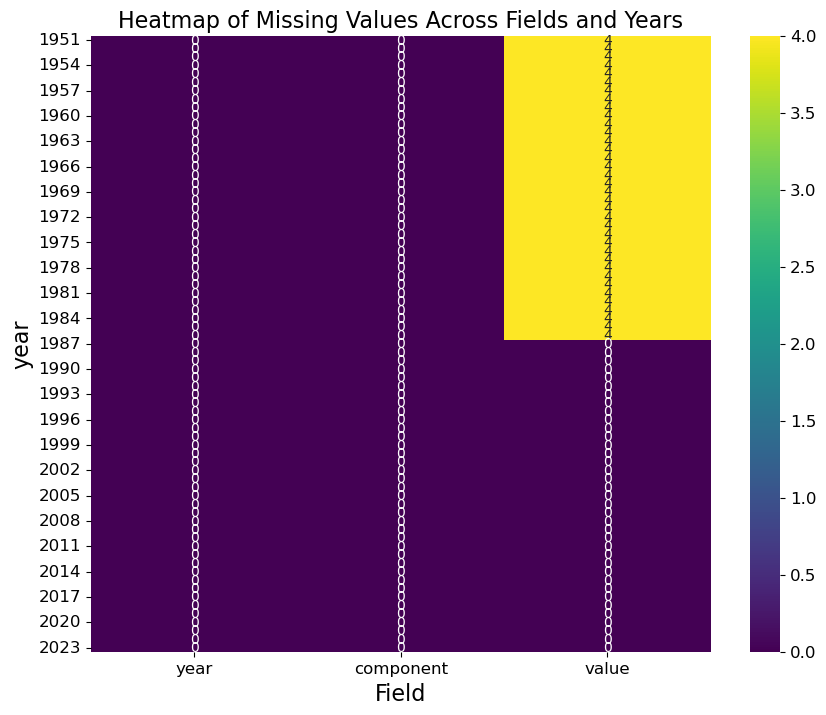

In [12]:


# Check for missing values
missing_values = df.isnull()

# Group by 'Year' and count missing values for each field
missing_summary = missing_values.groupby(df.year).sum()


# Creating a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(missing_summary, annot=True, cmap='viridis', fmt='d')
plt.title('Heatmap of Missing Values Across Fields and Years')
plt.ylabel('year')
plt.xlabel('Field')
plt.show()


In [13]:
# Unique values in non-numeric columns
{col: df[col].unique() for col in df.select_dtypes(include='object').columns}

{'component': array(['Annual births', 'Annual deaths', 'Natural increase', 'Immigrants',
        'Emigrants', 'Net migration', 'Population change', 'Population'],
       dtype=object)}

In [14]:
# Filter for rows where 'value' is missing using .isnull() method
missing_value = df.value.isnull()


# Filter the original DataFrame using this mask
df_missing_value = df[missing_value]

# Find the maximum year in this filtered DataFrame
last_year_missing = df_missing_value.year.max()  

print(f"The last year with missing data in the 'VALUE' field is: {last_year_missing}")

The last year with missing data in the 'VALUE' field is: 1986


In [15]:
# Pivoting the DataFrame
df_pivot = df.pivot(index='year', columns='component', values='value')

# Resetting the index to make 'year' a column
df_pivot.reset_index(inplace=False)

df_pivot.columns

Index(['Annual births', 'Annual deaths', 'Emigrants', 'Immigrants',
       'Natural increase', 'Net migration', 'Population', 'Population change'],
      dtype='object', name='component')

In [16]:
# Renaming the remaining columns according to pythonic conventions
df_pivot= df_pivot.rename(columns={
    'Annual births': 'births',
    'Annual deaths': 'deaths',
    'Natural increase': 'natural',
    'Net migration': 'migration',
    'Population change': 'change',
    'Emigrants':'emigrants',
    'Immigrants':'immigrants',
    'Population':'population',
    '':'',
})


# Removing 'component' from column names
df_pivot.columns = [col.replace('component_', '') for col in df_pivot.columns]

# Displaying the updated column names
df_pivot.columns

Index(['births', 'deaths', 'emigrants', 'immigrants', 'natural', 'migration',
       'population', 'change'],
      dtype='object')

In [17]:
#preview changes
df_pivot = df_pivot.reset_index()
df_pivot.head()

,year,births,deaths,emigrants,immigrants,natural,migration,population,change
0,1951,NaN,NaN,NaN,NaN,26.6,-35.0,2960.6,-8.4
1,1952,NaN,NaN,NaN,NaN,27.3,-35.0,2952.9,-7.7
2,1953,NaN,NaN,NaN,NaN,29.1,-33.0,2949.0,-3.9
3,1954,NaN,NaN,NaN,NaN,28.2,-36.0,2941.2,-7.8
4,1955,NaN,NaN,NaN,NaN,24.7,-45.0,2920.9,-20.3


## visualize missing values

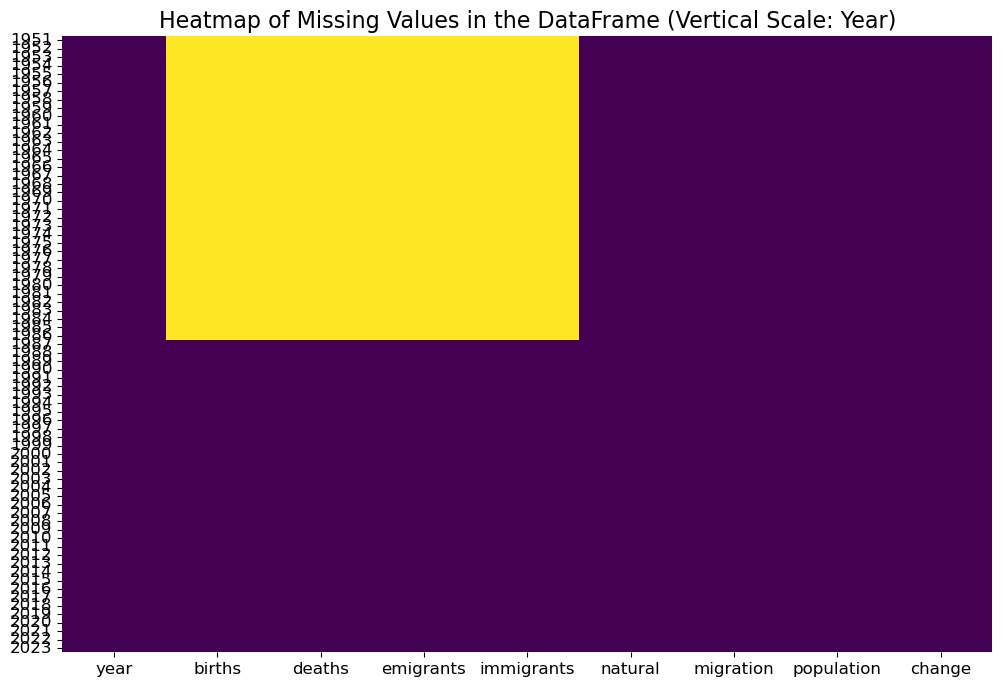

In [18]:

# Creating a DataFrame to visualize missing values
missing_values_heatmap_df = df_pivot.isnull()

# Creating a heatmap with 'year' as the vertical scale
plt.figure(figsize=(12, 8))
sns.heatmap(missing_values_heatmap_df, yticklabels=df_pivot['year'], cbar=False, cmap='viridis')
plt.title('Heatmap of Missing Values in the DataFrame (Vertical Scale: Year)')
plt.savefig('../images/change_component_missing_heatmap.png')
plt.show()

In [19]:
# Count of NaNs per Column for df_pivot
nan_count_per_column_pivot = df_pivot.isnull().sum()

# Percentage of NaNs per Column for df_pivot
nan_percentage_per_column_pivot = (df_pivot.isnull().mean() * 100).round(2)

# Count of NaNs per Year for df_pivot
nan_count_per_year_pivot = df_pivot.isnull().sum(axis=1)

# Year-wise Percentage of NaNs for df_pivot
nan_percentage_per_year_pivot = (df_pivot.isnull().mean(axis=1) * 100).round(2)

nan_count_per_column_pivot, nan_percentage_per_column_pivot, nan_count_per_year_pivot, nan_percentage_per_year_pivot



(year           0
 births        36
 deaths        36
 emigrants     36
 immigrants    36
 natural        0
 migration      0
 population     0
 change         0
 dtype: int64,
 year           0.00
 births        49.32
 deaths        49.32
 emigrants     49.32
 immigrants    49.32
 natural        0.00
 migration      0.00
 population     0.00
 change         0.00
 dtype: float64,
 0     4
 1     4
 2     4
 3     4
 4     4
      ..
 68    0
 69    0
 70    0
 71    0
 72    0
 Length: 73, dtype: int64,
 0     44.44
 1     44.44
 2     44.44
 3     44.44
 4     44.44
       ...  
 68     0.00
 69     0.00
 70     0.00
 71     0.00
 72     0.00
 Length: 73, dtype: float64)

In [20]:
df_pivot.columns

Index(['year', 'births', 'deaths', 'emigrants', 'immigrants', 'natural',
       'migration', 'population', 'change'],
      dtype='object')

In [21]:
# Initial backward fill
df_pivot_filled = df_pivot.bfill()

# Adjusting values to maintain differences
for index, row in df_pivot_filled.iterrows():
    if pd.isna(row['births']) and not pd.isna(row['deaths']):
        df_pivot_filled.at[index, 'births'] = row['deaths'] + row['natural']
    elif not pd.isna(row['births']) and pd.isna(row['deaths']):
        df_pivot_filled.at[index, 'deaths'] = row['births'] - row['natural']

    if pd.isna(row['immigrants']) and not pd.isna(row['emigrants']):
        df_pivot_filled.at[index, 'immigrants'] = row['emigrants'] + row['migration']
    elif not pd.isna(row['immigrants']) and pd.isna(row['emigrants']):
        df_pivot_filled.at[index, 'emigrants'] = row['immigrants'] - row['migration']

# Displaying the first few rows after filling and adjusting
df_pivot_filled.head()


,year,births,deaths,emigrants,immigrants,natural,migration,population,change
0,1951,61.2,32.2,40.2,17.2,26.6,-35.0,2960.6,-8.4
1,1952,61.2,32.2,40.2,17.2,27.3,-35.0,2952.9,-7.7
2,1953,61.2,32.2,40.2,17.2,29.1,-33.0,2949.0,-3.9
3,1954,61.2,32.2,40.2,17.2,28.2,-36.0,2941.2,-7.8
4,1955,61.2,32.2,40.2,17.2,24.7,-45.0,2920.9,-20.3


In [22]:
# Save the clean DataFrame to a new CSV file
df_pivot_filled.to_csv('../data/pivot_change_component.csv', index=False)

The strategy above  was to estimate 'Annual Births' and 'Annual Deaths' based on the 'Natural Increase' (which is Births - Deaths), and the patterns observed in the available data for years where these values are known. Here's a basic approach to this:

### Vital Events
- Annual deaths have been, in the main, rising  since 2005, while there's been a sharp decline in annual births since a peak in 2010.

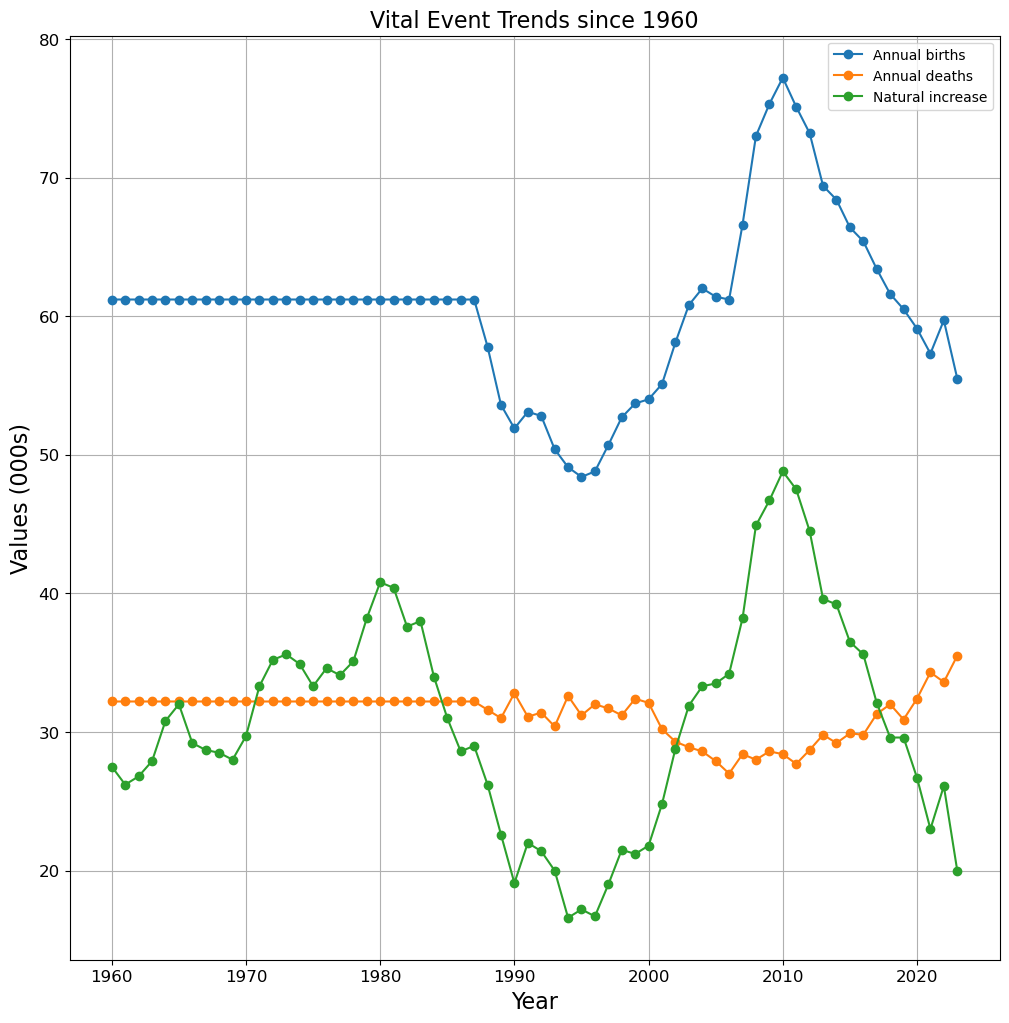

In [23]:


# Filter the DataFrame to include data from the start date onwards
start_date = 1960  # Define the start date for the plot
filtered_df = df_pivot_filled[df_pivot_filled['year'] >= start_date]

# Plotting the vital events
plt.figure(figsize=(12, 12))
plt.plot(filtered_df['year'], filtered_df['births'], marker='o', label='Annual births')
plt.plot(filtered_df['year'], filtered_df['deaths'], marker='o', label='Annual deaths')
plt.plot(filtered_df['year'], filtered_df['natural'], marker='o', label='Natural increase')
plt.title(f'Vital Event Trends since {start_date}')
plt.xlabel('Year')
plt.ylabel('Values (000s)')
plt.legend()
plt.grid(True)

# Save the plot before displaying it
plt.savefig('/mnt/data/change_componentvital_events.png')

# Then display the plot
plt.show()



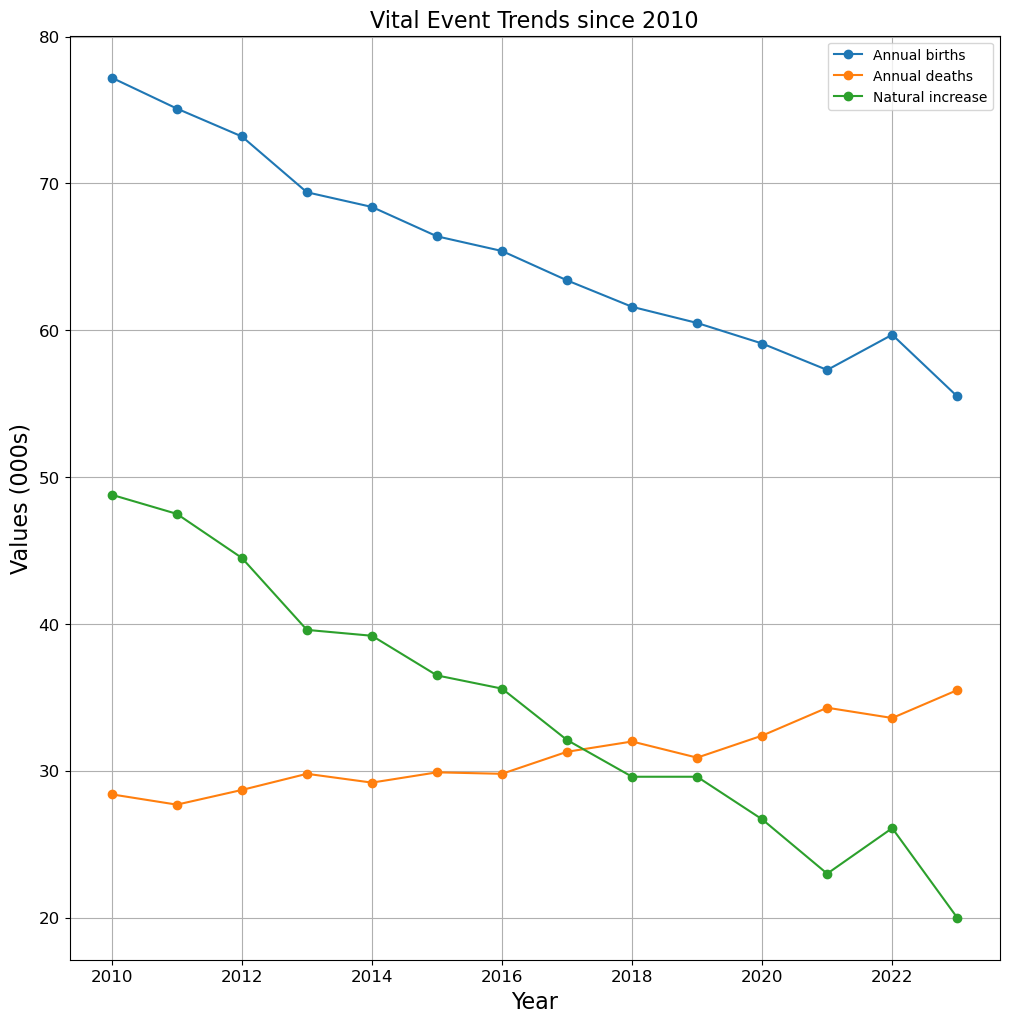

In [24]:

# Filter the DataFrame to include data from the start date onwards
start_date = 2010  # Define the start date for the plot
filtered_df = df_pivot_filled[df_pivot_filled['year'] >= start_date]

# Plotting the vital events
plt.figure(figsize=(12, 12))
plt.plot(filtered_df['year'], filtered_df['births'], marker='o', label='Annual births')
plt.plot(filtered_df['year'], filtered_df['deaths'], marker='o', label='Annual deaths')
plt.plot(filtered_df['year'], filtered_df['natural'], marker='o', label='Natural increase')
plt.title(f'Vital Event Trends since {start_date}')
plt.xlabel('Year')
plt.ylabel('Values (000s)')
plt.legend()
plt.grid(True)

# Save the plot before displaying it
plt.savefig('../images/change_componentvital_events{start_date}.png')

# Then display the plot
plt.show()



This plot illustrates the trend of Births Over Time since 2007


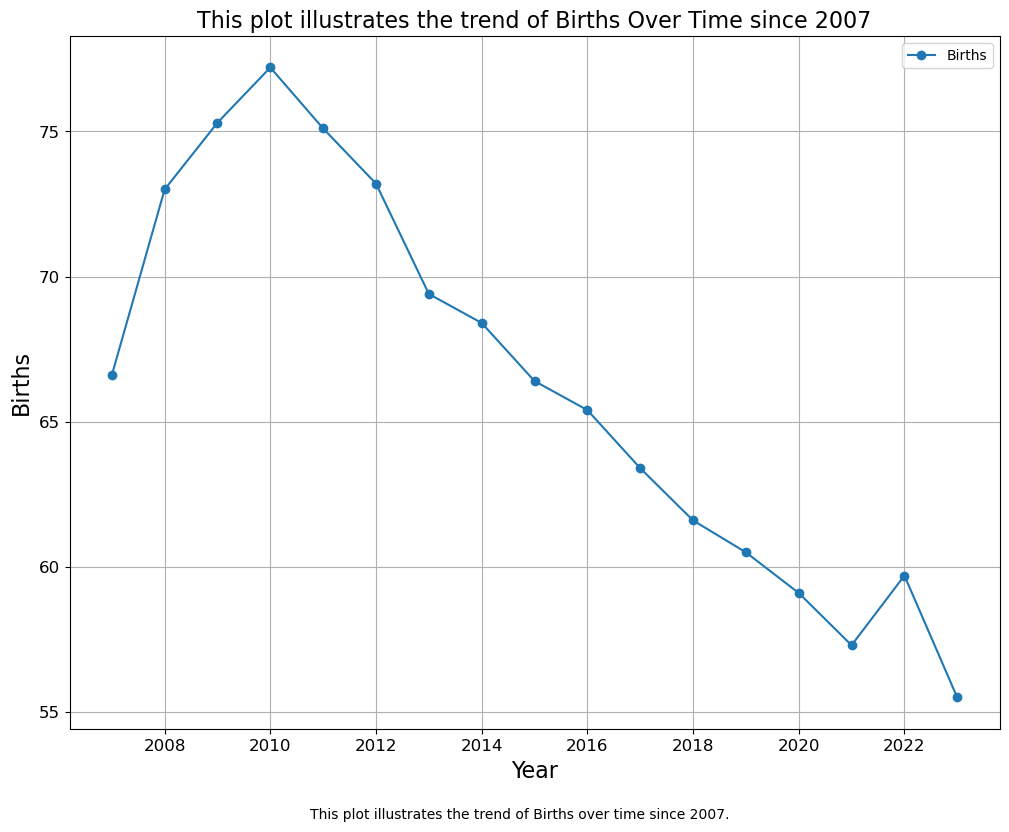

In [25]:

# Define string and input_date
string = 'births'  # Updated column name
input_date = 2007  # Define the input date

# Filter the data for the desired years
filtered_df = df_pivot_filled[df_pivot_filled['year'] >= input_date]

# Create a figure with a specified size
plt.figure(figsize=(12, 9))

# Plot the data with markers and labels
plt.plot(filtered_df['year'], filtered_df[string], marker='o', label=string)

# Set the title, axis labels, and legend
title = f'This plot illustrates the trend of {string.capitalize()} Over Time since {input_date}'
plt.title(title)
plt.xlabel('Year')
plt.ylabel(string.capitalize())

# Customize the legend label
plt.legend([string.capitalize()])

# Add a grid and a LaTeX-style caption with variables
plt.grid(True)
caption = f"This plot illustrates the trend of {string.capitalize()} over time since {input_date}."
plt.figtext(0.5, 0.01, caption, wrap=True, horizontalalignment='center', fontsize=10)

# Print the title as text to speed up report writing
print(title)

# Save the plot before displaying it
plt.savefig(f'../images/change_componentvital_{string}_since_{input_date}.png')

# Display the plot
plt.show()



This plot illustrates the trend of Deaths Over Time since 2009


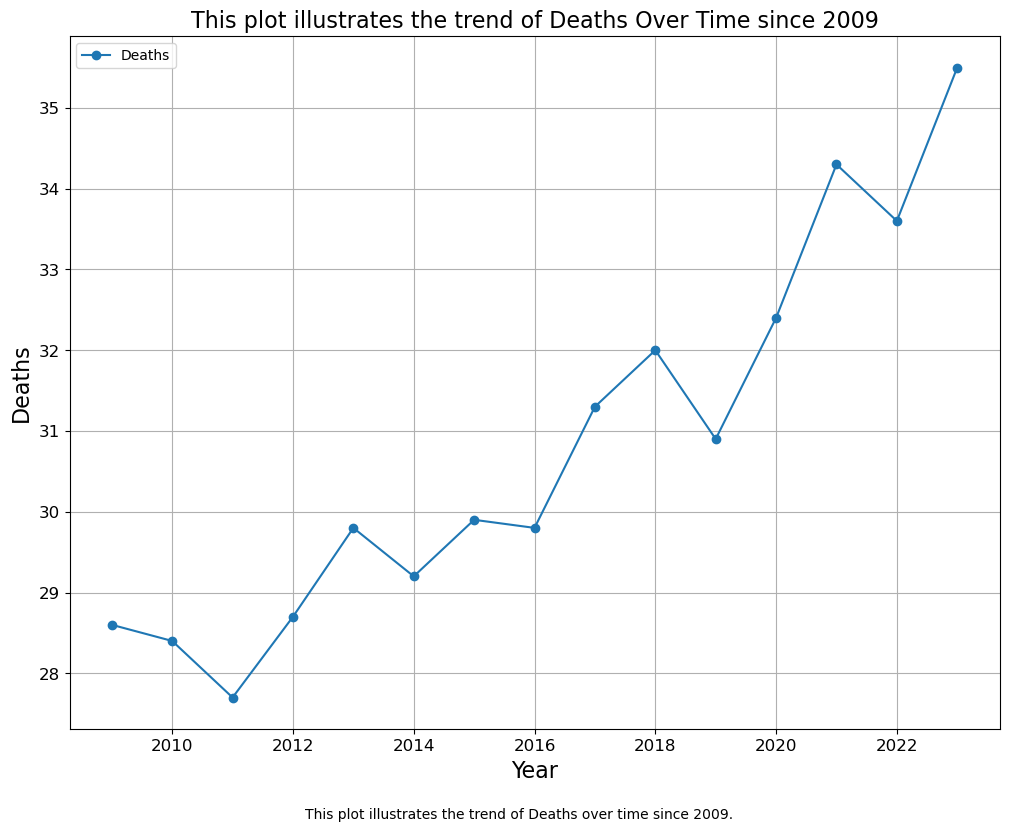

In [26]:


# Define string and input_date
string = 'deaths'  # Updated column name
input_date = 2009  # Define the input date

# Filter the data for the desired years
filtered_df = df_pivot_filled[df_pivot_filled['year'] >= input_date]

# Create a figure with a specified size
plt.figure(figsize=(12, 9))

# Plot the data with markers and labels
plt.plot(filtered_df['year'], filtered_df[string], marker='o', label=string)

# Set the title, axis labels, and legend
title = f'This plot illustrates the trend of {string.capitalize()} Over Time since {input_date}'
plt.title(title)
plt.xlabel('Year')
plt.ylabel(string.capitalize())

# Customize the legend label
plt.legend([string.capitalize()])

# Add a grid and a LaTeX-style caption with variables
plt.grid(True)
caption = f"This plot illustrates the trend of {string.capitalize()} over time since {input_date}."
plt.figtext(0.5, 0.01, caption, wrap=True, horizontalalignment='center', fontsize=10)

# Print the title as text to speed up report writing
print(title)

# Save the plot before displaying it
plt.savefig(f'../images/change_componentvital_{string}_since_{input_date}.png')

# Display the plot
plt.show()


In [27]:
filtered_df.columns

Index(['year', 'births', 'deaths', 'emigrants', 'immigrants', 'natural',
       'migration', 'population', 'change'],
      dtype='object')

The  Natural change in population  over time since 2005.


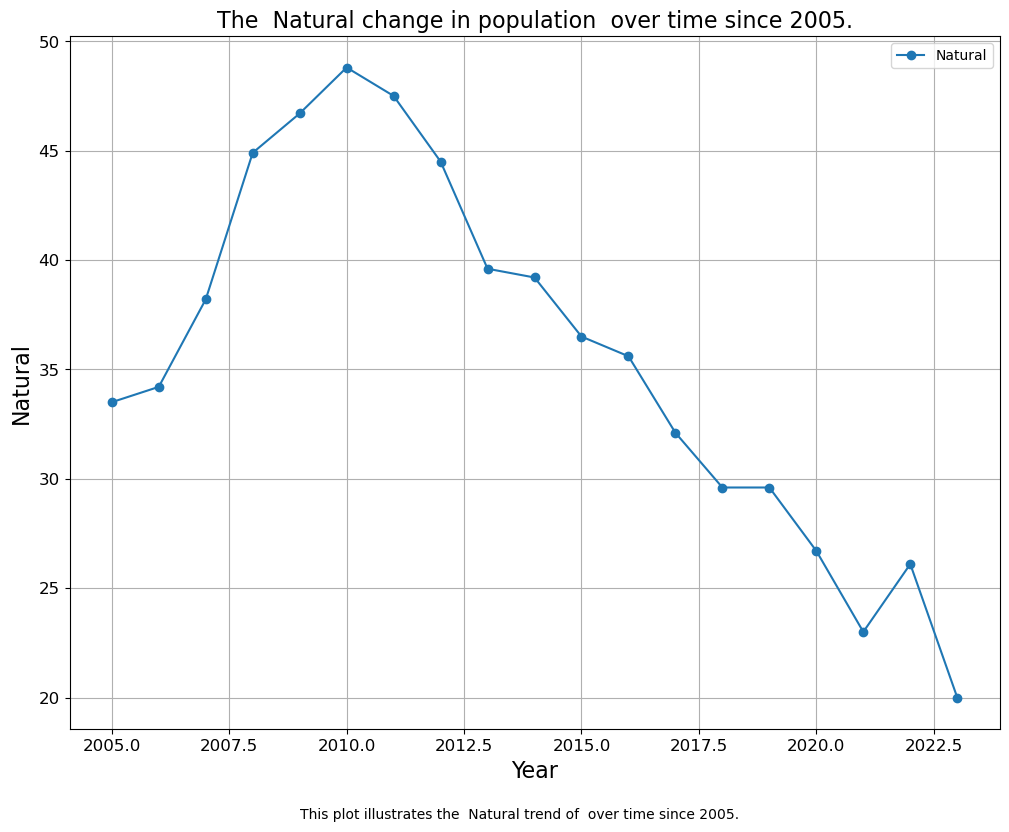

In [28]:

# Define the string and input date
string = 'natural'
input_date = 2005


# Filter the data for the desired years
filtered_df = df_pivot_filled[df_pivot_filled['year'] >= input_date]

# Create a figure with a specified size
plt.figure(figsize=(12, 9))

# Plot the data with markers and labels
plt.plot(filtered_df['year'], filtered_df[string], marker='o', label=string)

# Set the title, axis labels, and legend
title = f'The  {string.capitalize()} change in population  over time since {input_date}.'
plt.title(title)
plt.xlabel('Year')
plt.ylabel(string.capitalize())

# Customize the legend label
plt.legend([string.capitalize()])

# Add a grid and a LaTeX-style caption with variables
plt.grid(True)
caption = f"This plot illustrates the  {string.capitalize()} trend of  over time since {input_date}."
plt.figtext(0.5, 0.01, caption, wrap=True, horizontalalignment='center', fontsize=10)

# Print the title as text to speed up report writing
print(title)

# Save the plot before displaying it
plt.savefig(f'../images/change_componentvital_{string}_since_{input_date}.png')

# Display the plot
plt.show()


### Migration Patterns
- Immigration dropped in 2020, put showed a substantial increases since, especially from the rest of the world.


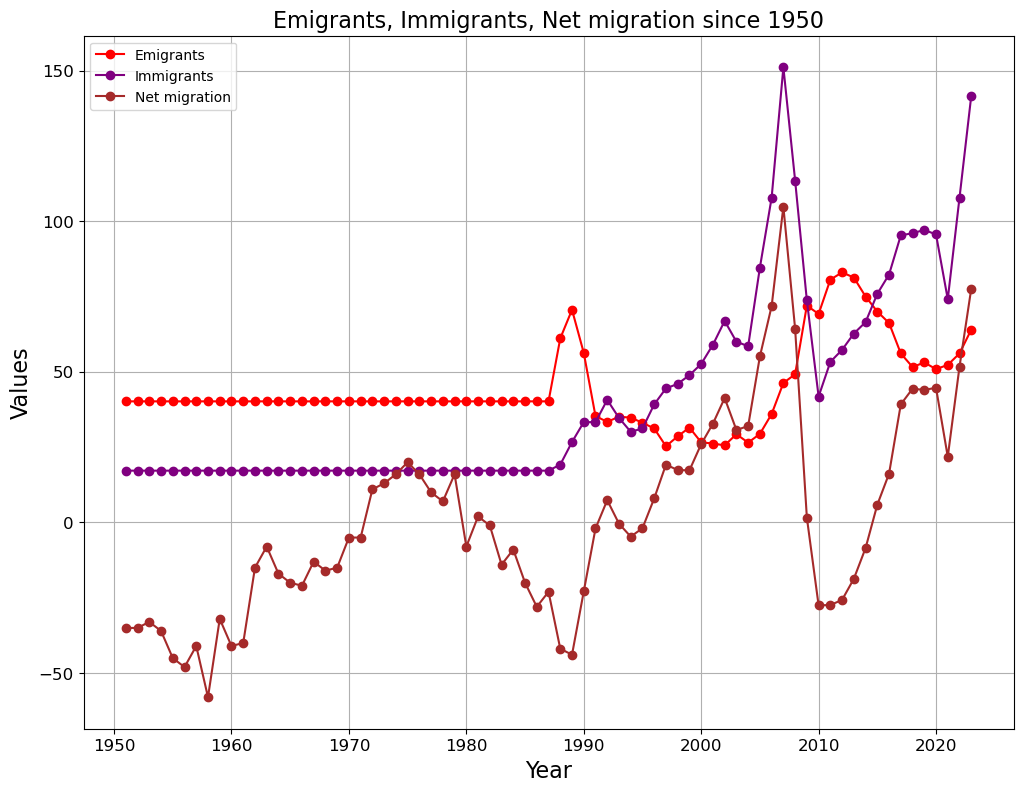

In [29]:

plt.figure(figsize=(12, 9))
plt.plot(df_pivot_filled['year'], df_pivot_filled['emigrants'], marker='o', label='Emigrants', color='red')
plt.plot(df_pivot_filled['year'], df_pivot_filled['immigrants'], marker='o', label='Immigrants', color='purple')
plt.plot(df_pivot_filled['year'], df_pivot_filled['migration'], marker='o', label='Net migration', color='brown')
plt.title('Emigrants, Immigrants, Net migration since 1950')
plt.xlabel('Year')
plt.ylabel('Values')
plt.legend()
plt.grid(True)

# Save the plot
plt.savefig('../data/change_component_flow_since_1950.png')

plt.show()




In [30]:
# strings = ['Annual births', 'Annual deaths', 'Natural increase', 'Emigrants', 'Immigrants', 'Net migration']

The  Emigrants change in population  over time since 2000.


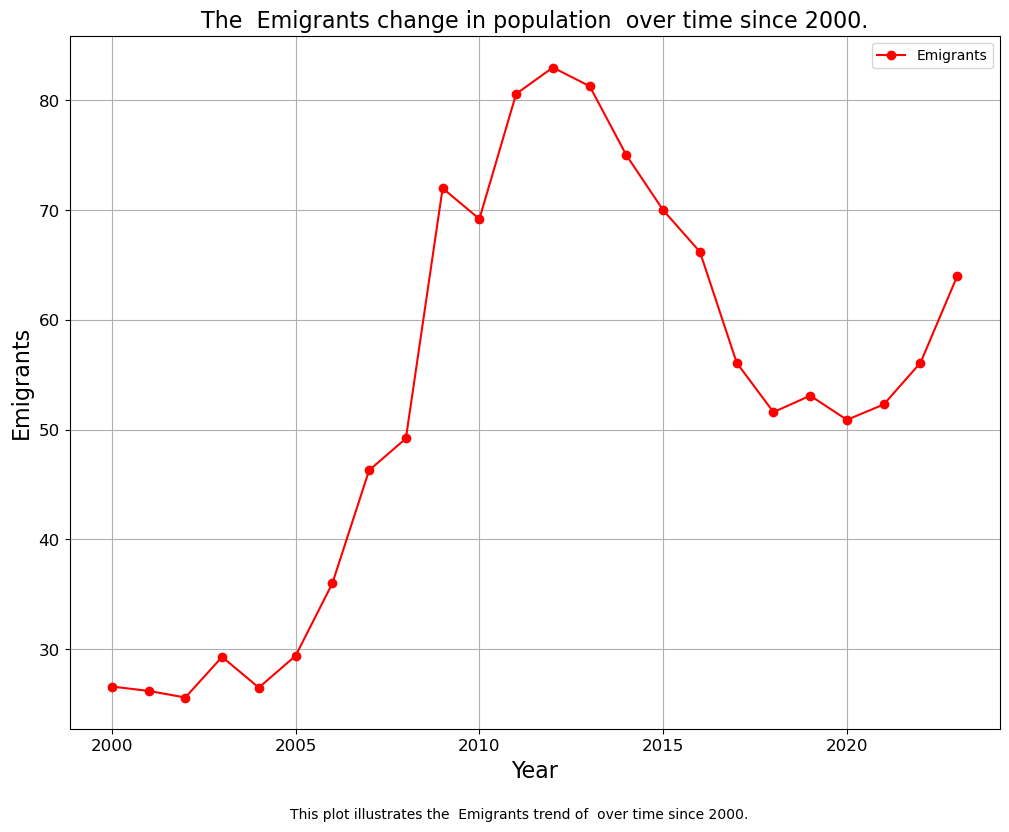

In [31]:

# Define the string and input date
string = 'emigrants'
input_date = 2000



# Filter the data for the desired years
filtered_df = df_pivot_filled[df_pivot_filled['year'] >= input_date]

# Create a figure with a specified size
plt.figure(figsize=(12, 9))

# Plot the data with markers and labels
plt.plot(filtered_df['year'], filtered_df[string], marker='o', label=string ,color='red')

# Set the title, axis labels, and legend
title = f'The  {string.capitalize()} change in population  over time since {input_date}.'
plt.title(title)
plt.xlabel('Year')
plt.ylabel(string.capitalize())

# Customize the legend label
plt.legend([string.capitalize()])

# Add a grid and a LaTeX-style caption with variables
plt.grid(True)
caption = f"This plot illustrates the  {string.capitalize()} trend of  over time since {input_date}."
plt.figtext(0.5, 0.01, caption, wrap=True, horizontalalignment='center', fontsize=10)

# Print the title as text to speed up report writing
print(title)

# Save the plot before displaying it
plt.savefig(f'../images/change_componentvital_{string}_since_{input_date}.png')

# Display the plot
plt.show()


The  Immigrants change in population  over time since 2000.


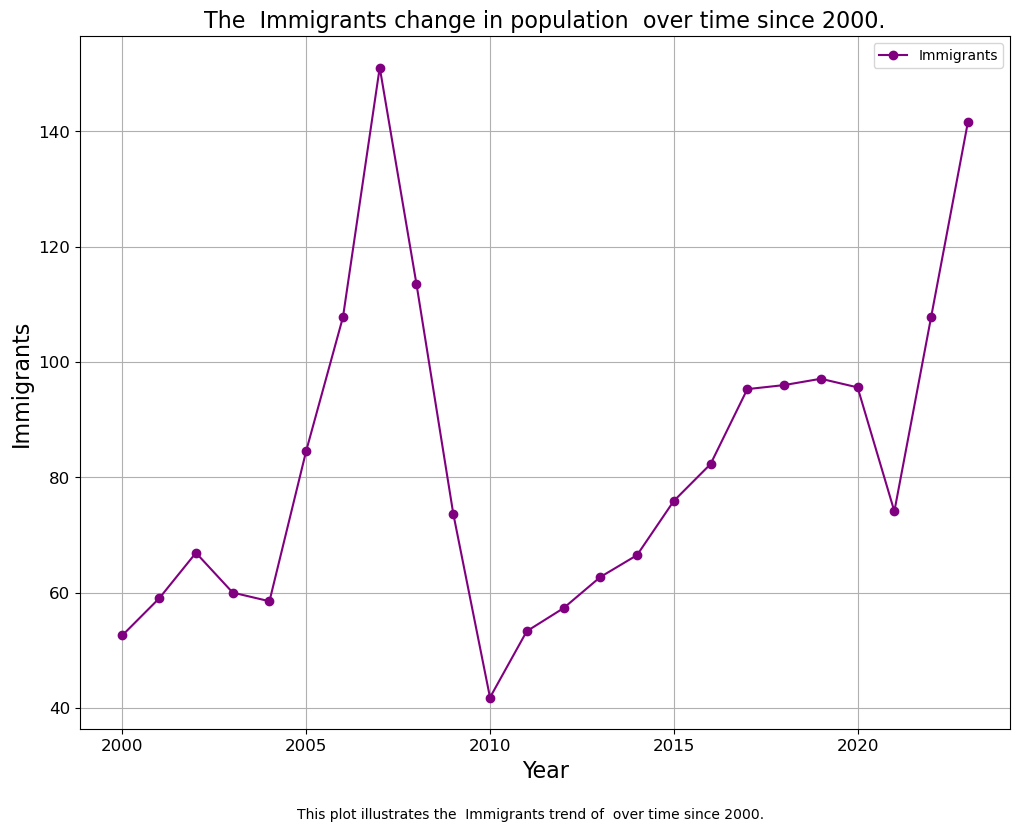

In [32]:


# Define the string and input date
string = 'immigrants'
input_date = 2000



# Filter the data for the desired years
filtered_df = df_pivot_filled[df_pivot_filled['year'] >= input_date]

# Create a figure with a specified size
plt.figure(figsize=(12, 9))

# Plot the data with markers and labels
plt.plot(filtered_df['year'], filtered_df[string], marker='o', label=string,color='purple')

# Set the title, axis labels, and legend
title = f'The  {string.capitalize()} change in population  over time since {input_date}.'
plt.title(title)
plt.xlabel('Year')
plt.ylabel(string.capitalize())

# Customize the legend label
plt.legend([string.capitalize()])

# Add a grid and a LaTeX-style caption with variables
plt.grid(True)
caption = f"This plot illustrates the  {string.capitalize()} trend of  over time since {input_date}."
plt.figtext(0.5, 0.01, caption, wrap=True, horizontalalignment='center', fontsize=10)

# Print the title as text to speed up report writing
print(title)

# Save the plot before displaying it
plt.savefig(f'../images/change_componentvital_{string}_since_{input_date}.png')

# Display the plot
plt.show()


The  Migration change in population  over time since 2000.


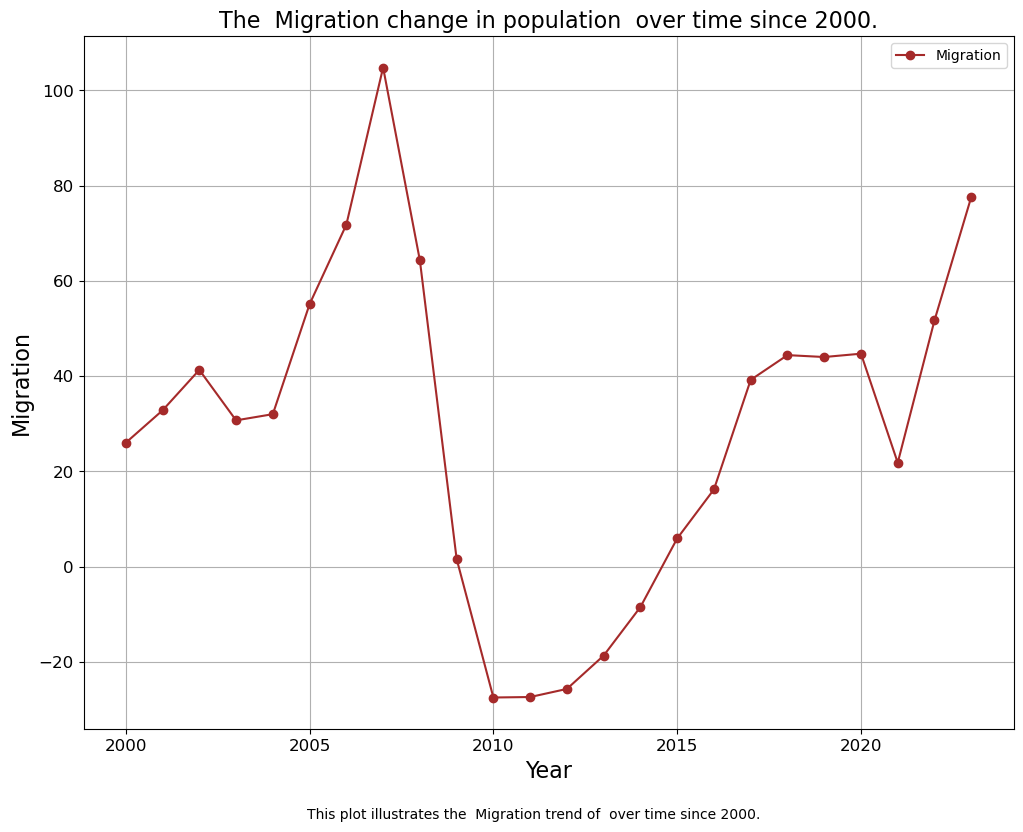

In [33]:

# Define the string and input date
string = 'migration'
input_date = 2000


# Filter the data for the desired years
filtered_df = df_pivot_filled[df_pivot_filled['year'] >= input_date]

# Create a figure with a specified size
plt.figure(figsize=(12, 9))

# Plot the data with markers and labels
plt.plot(filtered_df['year'], filtered_df[string], marker='o', label=string,color='brown')

# Set the title, axis labels, and legend
title = f'The  {string.capitalize()} change in population  over time since {input_date}.'
plt.title(title)
plt.xlabel('Year')
plt.ylabel(string.capitalize())

# Customize the legend label
plt.legend([string.capitalize()])

# Add a grid and a LaTeX-style caption with variables
plt.grid(True)
caption = f"This plot illustrates the  {string.capitalize()} trend of  over time since {input_date}."
plt.figtext(0.5, 0.01, caption, wrap=True, horizontalalignment='center', fontsize=10)

# Print the title as text to speed up report writing
print(title)

# Save the plot before displaying it
plt.savefig(f'../images/change_componentvital_{string}_since_{input_date}.png')

# Display the plot
plt.show()


### Ongoing research
These mortality, fertility, and migration figures will be merged with population and other data from  [Central Statistics Office in Ireland  population of Ireland series.](https://data.cso.ie/product/pme)